In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np 
import torch

%aimport algorithms
from algorithms import *

from inv_env_simplified import DiscreteMESCEnv
from utils import plot_reward_evolution, plot_reward_distribution, setup_model_saving

%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt

# **1. Environment definition**
[comment]: <> (https://github.com/MauroLuzzatto/Q-Learning-Demo-Play-nChain/blob/master/q_learning_notebook.ipynb)
The goal of this coursework is to find an inventory policy that learns the optimal way of placing orders, that is, the one that maximizes episodic returns. The policy model should therefore inform the decision-maker about when to place a replenishment order and the quantity to order to fulfill customers' demand.

Inventory optimisaiton is a sequential decision-making problem by nature. Thus, it can be modeled as a Markov Decision Process (MDP), which is the backbone of Reinforcement Learning (RL). The environment `MSCEnv` implements the underlying mathematical model is implemented in to represent multi-echelon supply chains. This coursework deals with the three-echelon supply chain depicted below.

<p align="center">
  <img src=".\SCstructure.png" alt="SupplyChainStructure" width="500"/>
</p>

In this environment, **actions** represent the **order quantity** placed by each stage of the supply chain at each time step and the **observation space** provides information about the **available storage capacity**. For the sake of simplicity, we limit both action and observation spaces to discrete values:
* Each action can take only 3 possible values.
<center>

| Index | Retailer 1 | Retailer 2 | DC |
|:--------:|:--------:|:--------:|:--------:|
| 0      | 0          | 0          | 0  |
| 1      | 10         | 10         | 20 |
| 2      | 20         | 20         | 100|
</center>

* The agent can observe only 4 possible values of the inventory position of each stage of the supply chain.
<center>

| Index | Retailer 1 | Retailer 2 | DC | Storage capacity level |
|:--------:|:--------:|:--------:|:--------:|:--------:|
| 0      | 0          | 0          | 0  | 0% |
| 1      | 20         | 20         | 50 | 33% |
| 2      | 40         | 40         | 100| 66% |
| 3      | 60         | 60         | 150| 100% |
</center>

Finally, the **reward** defined as the **profit** obtained by the entire supply chain after each period, considering that customers'demand as random variable following a Poisson distribution.
```python
reward = revenue - holding cost - fixed order cost - var order cost - penalty unsatisfied demand - penalty capacity violation
```

### **Basic usage**

Initialize the environment.

In [3]:
n_retailers = 2
n_DCs = 1
n_producers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_producers]
time_horizon = 4*7

# Initialize the environment
env = DiscreteMESCEnv(supply_chain_structure, num_periods = time_horizon)

Explore action and observation spaces.

In [4]:
print(f"Total number of joint actions: {env.action_space.n}")
print("First 3 joint actions:")
for i,a in enumerate(list(env.action_lookup.keys())[0:3]):
    print(f"    Index {i} matches action {a}")

print(f"\nTotal number of states: {env.observation_space.n}")
print("First 3 possible values of the observations:")
for i,a in enumerate(list(env.observation_lookup.keys())[0:3]):
    print(f"    Index {i} matches observation {a}")

Total number of joint actions: 27
First 3 joint actions:
    Index 0 matches action (0, 0, 0)
    Index 1 matches action (0, 0, 50)
    Index 2 matches action (0, 0, 100)

Total number of states: 64
First 3 possible values of the observations:
    Index 0 matches observation (np.float64(0.0), np.float64(0.0), np.float64(0.0))
    Index 1 matches observation (np.float64(0.0), np.float64(0.0), np.float64(50.0))
    Index 2 matches observation (np.float64(0.0), np.float64(0.0), np.float64(100.0))


Interact with the environment.

In [5]:
# Get current observation of the state
current_state = env.obs

# Sample a random action
random_action = env.sample_action()
# Get the index of the sampled action
random_action_idx = env.action_lookup[tuple(random_action)]

# Take action, observe reward, and move to the next state
next_state , reward , episode_done , additional_info = env.step(random_action)

print(f"Current state: {current_state}\nRandom action: {random_action}\nNext state: {next_state}\nReward: {reward}")

Current state: [ 20  20 100]
Random action: [  0  20 100]
Next state: [  0  40 150]
Reward: 13.0


# **2. Policy training**
To optimise an inventory policy, different methods can be used. 
- **Heuristic methods** that rely on classic inventory control policies, like the (s,S) policy
- **Meta-heuristic algorithms** that iteratively explore the search space by mimiking natural phenomena, like simulated annealing (SA) or particle-swarm optimisation (PSO).
- **RL-specific algorithms**, such as Q-learning or REINFORCE.

Your task is to implement the off-policy TD control algorithm known as **Q-learning** (Watkins, 1989), which is shown below in procedural form.
<figure>
<p align="center">
<img src=".\Qlearning_algorithm.png" style="width:50%" align="center">
</p>
<figcaption align = "center"> Source: Sutton, R., & Barto, A. (2018). Reinforcement learning: an introduction. MIT Press. </figcaption>
</figure>

#### **Helper Functions**

Before getting into the actual implementation of the optimisation algorithm, two functions have been pre-coded for you:

* `greedy_policy` --> selects action with highest action value Q(s,a).
* `epsilon_greedy_policy` --> samples a random action with probability $\varepsilon$ and follows a greedy policy with probability $(1-\varepsilon)$.

Note that we will use both of these function to evaluate your submission. Should you wish to use a different sampling function, you have to define it **WITHIN** your algorithm!

```python
def greedy_policy(env, state_idx, Q): 
    # Get index of the optimal action
    action_idx = np.argmax(Q[state_idx,:])
    # Map action index to actual action value
    return np.array(list(env.action_lookup.keys())[action_idx]) , action_idx

def epsilon_greedy_policy(env, state, Q, epsilon):
    if np.random.rand() < epsilon:
        # Explore: choose a random action
        action = env.sample_action()
        return action , env.action_lookup[tuple(action)]
    else:
        # Exploit: choose best action 
        return greedy_policy(env,state,Q)
```

### **Implementation**

The function `learn_action_value_function` contains the code to run the Q-learning algorithm and can be found in the file [`Qlearning.py`](.\Qlearning.py) under the folder `algorithms`. It returns two objects:
* `Q_table`: optimal Q(s,a) table
* `plot_info`: data to generate learning curves.

The performance of the given code can be improved by:
* Tuning hyperparameters
* Adding new features (e.g., learning rate decay or iteratively reducing $\varepsilon$)

Participants are encouraged to modify the code as long as they **respect the structure of the template**. This is vital to ensure compliance with our testing platform. 

Note that we will test your implementation on a different environment with a **limited budget**. In the final evaluation, `max_iter` and `max_time` will be limited to 1000 iterations or episodes and 10 s, respectively.

In [6]:
Q_table, plot_info = q_learning_alg(env,
                                    max_episodes = 1000 , # Total training episodes
                                    max_time = 10 , # Maximum execution time
                                    epsilon = 0.25 , # Probability of taking a random action
                                    alpha = 0.001, # Learning rate
                                    gamma = 0.99, # Discount factor
                                    )

100%|██████████| 1000/1000 [00:06<00:00, 148.96it/s]


Plot learning curve.

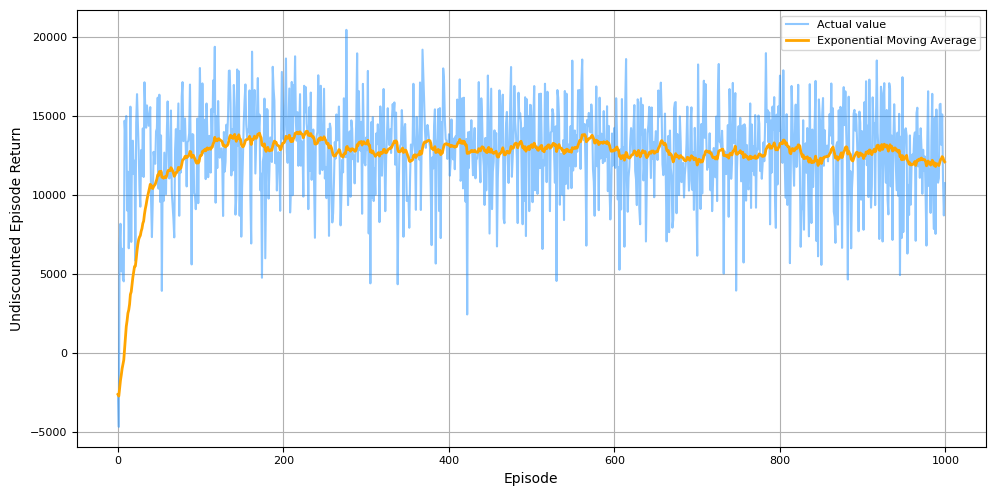

In [7]:
plot_reward_evolution(plot_info["episode"],plot_info["total_reward"], xlabel="Episode", ylabel="Undiscounted Episode Return")

# **5. Policy evaluation**
### **5.1. Test data**: get new demand scenarios
The variable test_demand_dataset contains 50 samples of demand scenarios, each with `env.n_periods` days, that will be used for testing and comparing the extrapolation capabilities of the different policies.

In [8]:
import pickle
# Open the file in binary mode
with open("test_dataset.pickle", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    test_demand_dataset = pickle.load(file)

### **5.2. Evaluation**
To evaluate the optimal inventory control policy, we will use the $Q^*(s,a)$ table to always choose the best action $a$ for a given state $s$. The function `evaluate_action_value_function` computes the total undiscounted return of each episode in `test_demand_dataset` following the policy given by `Q_table` and returns a list with the result of each episode.

In [9]:
reward_list = evaluate_action_value_function(env, test_demand_dataset, Q_table)

Performance of the inventory management policy in the test set:
 - Average reward: 5723
 - Reward standard deviation: 1741.94


##### **Results visualization**
Plot the distribution of rewards and compare your results to those obtained with two other benchmarking poilicies, which have been evaluated using the same `test_demand_dataset`. 

The policies considered for benchmarking are:
* A neural network with the same architecture as the one used in this notebook that has been trained using the algorithm Simulated Annealing.
* An (s,S)-policy, which is a simple heuristic strategy where an order is placed to bring the inventory up to a target maximum level (S) only when the on-hand inventory, or inventory position, falls to or below a reorder point (s).

In [10]:
from common import DiscretePolicyNetwork, evaluate_policy

benchmarking_policies = ['local_search']
distributions = {k: None for k in benchmarking_policies}

policy = DiscretePolicyNetwork(input_size=env.observation_space.shape[0], 
                               output_size=env.action_space.n,
                                )
for alg in benchmarking_policies:
    path = r".\benchmarking\policy_"+ alg + ".pt"
    policy.load_state_dict(torch.load(path))
    distributions[alg] = evaluate_policy(policy, env, test_demand_dataset )


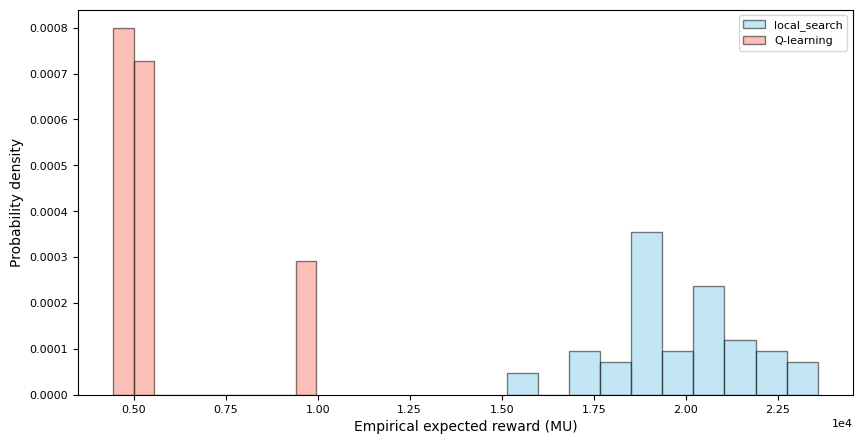

In [11]:
distributions["Q-learning"] = reward_list
plot_reward_distribution(np.vstack([distributions[alg] for alg in distributions.keys()]).T, labels = list(distributions.keys()))
